<a href="https://colab.research.google.com/github/shykiu77/PLN_QA_LLM_2025_Melo_Carlos/blob/main/PLN_QA_LLM_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Instalação de arquivos necessários
!pip install python-docx -q
!pip install pymupdf -q
!pip install sentence-transformers -q
!pip install faiss-cpu -q
!pip install transformers -q

In [20]:
# Importação de bibliotecas
from google.colab import files
from docx import Document
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import matplotlib.pyplot as plt
import fitz
import re
import faiss

In [21]:
# Upload manual dos arquivos necessários (encontrados na pasta 'content')
uploaded = files.upload()

Saving DICIONARIO_DE_DADOS.docx to DICIONARIO_DE_DADOS (1).docx
Saving doencas_respiratorias_cronicas.pdf to doencas_respiratorias_cronicas (1).pdf


In [22]:
# Funções para extrair conteúdo dos arquivos

# Extração de texto do .docx
def extract_text_from_docx(file_path):
  doc = Document(file_path)
  texts = []

  # Extrai textos fora das tabelas
  for p in doc.paragraphs:
    text = p.text.strip()
    if text:
      texts.append(text)

  # Extrai texto das tabelas
  for table in doc.tables:
    for row in table.rows:
      row_text = []
      for cell in row.cells:
        cell_text = cell.text.strip()
        if cell_text:
          row_text.append(cell_text)
      if row_text:
        texts.append(' | '.join(row_text))

  return '\n'.join(texts)


# Extração de texto do .pdf
def extract_text_from_pdf(file_path):
    doc = fitz.open(file_path)
    full_text = []

    for page in doc:
        text = page.get_text("text")
        # Limpeza leve: remove espaços múltiplos, quebra em parágrafos
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\s([.,;:])', r'\1', text)  # remove espaço antes de pontuação
        full_text.append(text.strip())

    return "\n".join(full_text)

In [23]:
# Função para dividir em blocos menores
def split_context(text, max_len=1500):
    sentences = text.split('. ')
    blocks, current = [], ""
    for s in sentences:
        if len(current + s) <= max_len:
            current += s + ". "
        else:
            blocks.append(current.strip())
            current = s + ". "
    if current:
        blocks.append(current.strip())
    return blocks


In [24]:
# Extração dos documentos
docx_text = extract_text_from_docx('/content/DICIONARIO_DE_DADOS.docx')
pdf_text = extract_text_from_pdf('/content/doencas_respiratorias_cronicas.pdf')

In [25]:
# Aplicação dos modelos nas perguntas

# Modelos de teste
model_names = [
    "deepset/roberta-base-squad2",
    "distilbert-base-cased-distilled-squad",
    "timpal0l/mdeberta-v3-base-squad2"
]

documentos = {
    "Dicionário de Dados": docx_text,
    "Doenças Respiratórias Crônicas": pdf_text
}

# Perguntas e respostas para cada documento
perguntas_respostas_por_doc = {
    "Dicionário de Dados": {
        "Qual o nome da tabela LFCES004 no banco de produção federal?": "TB_ESTABELECIMENTO",
        "Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?": "Quantidade de Leitos Disponíveis para o SUS.( Para os Estabelecimentos vinculados ao SUS.)",
        "Quais são os domínios do campo INDGESTOR, da tabela FCESGEST?": "1 – Secretaria Estadual, 2 – Região de Saúde, 3 – Secretaria Municipal Não Pleno, 4 – Módulo Assistencial, 5 – Distrito Sanitário, 6 – DataSus, 7 – 5éc. Municipal Pleno, 8 – Capital, 9 – Microrregião"
    },
    "Doenças Respiratórias Crônicas": {
        "Quais são os principais fatores de risco preveníveis para doenças respiratórias crônicas (DRC)?": "Tabagismo, poluição ambiental, alérgenos, agentes ocupacionais, pneumonia, bronquiolite e tuberculose.",
        "Qual é a definição clássica de sintomático respiratório?": "É o indivíduo que apresenta tosse, associada ou não a outra alteração respiratória, por algumas semanas.",
        "Como a tosse pode ser classificada?": "Em aguda até três semanas de duração; subaguda de três a oito semanas; e crônica se superior a oito semanas."
    }
}

resultados = []

for model_name in model_names:
    print(f"Rodando Modelo: {model_name}")
    qa = pipeline("question-answering", model=model_name, tokenizer=model_name)

    for nome_doc, perguntas_respostas in perguntas_respostas_por_doc.items():
        contexto = documentos[nome_doc]
        blocos = split_context(contexto, 1500)

        for pergunta, resposta_correta in perguntas_respostas.items():
            print(f"Rodando Pergunta: {pergunta}")
            melhor_resposta = {"answer": "", "score": 0.0}
            for bloco in blocos:
              if not bloco.strip():
                continue
              try:
                resultado = qa(question=pergunta, context=bloco)
                if resultado["score"] > melhor_resposta["score"]:
                  melhor_resposta = resultado
              except Exception as e:
                print(f"Erro ao processar bloco: {e}")
                continue

            resposta_modelo = melhor_resposta["answer"]
            score = melhor_resposta["score"]

            resultados.append({
                "Modelo": model_name,
                "Documento": nome_doc,
                "Pergunta": pergunta,
                "Resposta": resposta_modelo,
                "Resposta Esperada": resposta_correta,
                "Confiança": round(score, 4)
            })

Rodando Modelo: deepset/roberta-base-squad2


Device set to use cuda:0


Rodando Pergunta: Qual o nome da tabela LFCES004 no banco de produção federal?
Rodando Pergunta: Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?
Rodando Pergunta: Quais são os domínios do campo INDGESTOR, da tabela FCESGEST?
Rodando Pergunta: Quais são os principais fatores de risco preveníveis para doenças respiratórias crônicas (DRC)?
Rodando Pergunta: Qual é a definição clássica de sintomático respiratório?
Rodando Pergunta: Como a tosse pode ser classificada?
Rodando Modelo: distilbert-base-cased-distilled-squad


Device set to use cuda:0


Rodando Pergunta: Qual o nome da tabela LFCES004 no banco de produção federal?
Rodando Pergunta: Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?
Rodando Pergunta: Quais são os domínios do campo INDGESTOR, da tabela FCESGEST?
Rodando Pergunta: Quais são os principais fatores de risco preveníveis para doenças respiratórias crônicas (DRC)?
Rodando Pergunta: Qual é a definição clássica de sintomático respiratório?
Rodando Pergunta: Como a tosse pode ser classificada?
Rodando Modelo: timpal0l/mdeberta-v3-base-squad2


Device set to use cuda:0


Rodando Pergunta: Qual o nome da tabela LFCES004 no banco de produção federal?
Rodando Pergunta: Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?
Rodando Pergunta: Quais são os domínios do campo INDGESTOR, da tabela FCESGEST?
Rodando Pergunta: Quais são os principais fatores de risco preveníveis para doenças respiratórias crônicas (DRC)?
Rodando Pergunta: Qual é a definição clássica de sintomático respiratório?
Rodando Pergunta: Como a tosse pode ser classificada?


In [26]:
# Avaliação manual + Similaridade semântica

# Avaliação manual
def avaliar_resposta(r_modelo, r_correta):
    r_modelo = r_modelo.lower().strip()
    r_correta = r_correta.lower().strip()
    if r_modelo == r_correta:
        return "✔️"
    elif r_modelo in r_correta or r_correta in r_modelo:
        return "➖"
    else:
        return "❌"

# Carrega modelo para embeddings
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Tabela com avaliações
avaliacoes = []

for r in resultados:
    r_modelo = r["Resposta"]
    r_correta = r["Resposta Esperada"]

    # Similaridade
    emb1 = embedding_model.encode(r_modelo, convert_to_tensor=True)
    emb2 = embedding_model.encode(r_correta, convert_to_tensor=True)
    similaridade = util.cos_sim(emb1, emb2).item()

    # Avaliação manual
    avaliacao = avaliar_resposta(r_modelo, r_correta)

    avaliacoes.append({
        "Documento": r["Documento"],
        "Pergunta": r["Pergunta"],
        "Modelo": r["Modelo"],
        "Resposta": r_modelo,
        "Resposta Esperada": r_correta,
        "Avaliação": avaliacao,
        "Similaridade": round(similaridade, 4),
        "Confiança": r["Confiança"]
    })



Resultados para: deepset/roberta-base-squad2


,Documento,Pergunta,Modelo,Resposta,Resposta Esperada,Avaliação,Similaridade,Confiança
0,Dicionário de Dados,Qual o nome da tabela LFCES004 no banco de produção federal?,deepset/roberta-base-squad2,NOT NULL,TB_ESTABELECIMENTO,❌,0.191800,0.320000
1,Dicionário de Dados,"Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?",deepset/roberta-base-squad2,LFCES002,Quantidade de Leitos Disponíveis para o SUS.( Para os Estabelecimentos vinculados ao SUS.),❌,-0.062700,0.009400
2,Dicionário de Dados,"Quais são os domínios do campo INDGESTOR, da tabela FCESGEST?",deepset/roberta-base-squad2,NFCES110,"1 – Secretaria Estadual, 2 – Região de Saúde, 3 – Secretaria Municipal Não Pleno, 4 – Módulo Assistencial, 5 – Distrito Sanitário, 6 – DataSus, 7 – 5éc. Municipal Pleno, 8 – Capital, 9 – Microrregião",❌,0.007600,0.038200
3,Doenças Respiratórias Crônicas,Quais são os principais fatores de risco preveníveis para doenças respiratórias crônicas (DRC)?,deepset/roberta-base-squad2,as crianças,"Tabagismo, poluição ambiental, alérgenos, agentes ocupacionais, pneumonia, bronquiolite e tuberculose.",❌,0.147200,0.104400
4,Doenças Respiratórias Crônicas,Qual é a definição clássica de sintomático respiratório?,deepset/roberta-base-squad2,se possível,"É o indivíduo que apresenta tosse, associada ou não a outra alteração respiratória, por algumas semanas.",❌,0.258800,0.228200
5,Doenças Respiratórias Crônicas,Como a tosse pode ser classificada?,deepset/roberta-base-squad2,quanto à gravidade,Em aguda até três semanas de duração; subaguda de três a oito semanas; e crônica se superior a oito semanas.,❌,0.281600,0.268600




Resultados para: distilbert-base-cased-distilled-squad


,Documento,Pergunta,Modelo,Resposta,Resposta Esperada,Avaliação,Similaridade,Confiança
6,Dicionário de Dados,Qual o nome da tabela LFCES004 no banco de produção federal?,distilbert-base-cased-distilled-squad,Ensinos F – Hosp,TB_ESTABELECIMENTO,❌,0.205600,0.480100
7,Dicionário de Dados,"Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?",distilbert-base-cased-distilled-squad,Ensinos F – Hosp,Quantidade de Leitos Disponíveis para o SUS.( Para os Estabelecimentos vinculados ao SUS.),❌,0.359600,0.669500
8,Dicionário de Dados,"Quais são os domínios do campo INDGESTOR, da tabela FCESGEST?",distilbert-base-cased-distilled-squad,Ensinos F – Hosp,"1 – Secretaria Estadual, 2 – Região de Saúde, 3 – Secretaria Municipal Não Pleno, 4 – Módulo Assistencial, 5 – Distrito Sanitário, 6 – DataSus, 7 – 5éc. Municipal Pleno, 8 – Capital, 9 – Microrregião",❌,0.170900,0.581900
9,Doenças Respiratórias Crônicas,Quais são os principais fatores de risco preveníveis para doenças respiratórias crônicas (DRC)?,distilbert-base-cased-distilled-squad,Broncodilatadores,"Tabagismo, poluição ambiental, alérgenos, agentes ocupacionais, pneumonia, bronquiolite e tuberculose.",❌,0.258500,0.126300
10,Doenças Respiratórias Crônicas,Qual é a definição clássica de sintomático respiratório?,distilbert-base-cased-distilled-squad,Quadro 5.5,"É o indivíduo que apresenta tosse, associada ou não a outra alteração respiratória, por algumas semanas.",❌,0.068600,0.308200
11,Doenças Respiratórias Crônicas,Como a tosse pode ser classificada?,distilbert-base-cased-distilled-squad,Aguda,Em aguda até três semanas de duração; subaguda de três a oito semanas; e crônica se superior a oito semanas.,➖,0.450400,0.496300




Resultados para: timpal0l/mdeberta-v3-base-squad2


,Documento,Pergunta,Modelo,Resposta,Resposta Esperada,Avaliação,Similaridade,Confiança
12,Dicionário de Dados,Qual o nome da tabela LFCES004 no banco de produção federal?,timpal0l/mdeberta-v3-base-squad2,TB_ESTABELECIMENTO,TB_ESTABELECIMENTO,✔️,1.000000,0.868400
13,Dicionário de Dados,"Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?",timpal0l/mdeberta-v3-base-squad2,Quantidade de Leitos Disponíveis para o SUS.(,Quantidade de Leitos Disponíveis para o SUS.( Para os Estabelecimentos vinculados ao SUS.),➖,0.885800,0.171100
14,Dicionário de Dados,"Quais são os domínios do campo INDGESTOR, da tabela FCESGEST?",timpal0l/mdeberta-v3-base-squad2,1 – Secretaria Estadual,"1 – Secretaria Estadual, 2 – Região de Saúde, 3 – Secretaria Municipal Não Pleno, 4 – Módulo Assistencial, 5 – Distrito Sanitário, 6 – DataSus, 7 – 5éc. Municipal Pleno, 8 – Capital, 9 – Microrregião",➖,0.520300,0.011000
15,Doenças Respiratórias Crônicas,Quais são os principais fatores de risco preveníveis para doenças respiratórias crônicas (DRC)?,timpal0l/mdeberta-v3-base-squad2,"tabagismo,","Tabagismo, poluição ambiental, alérgenos, agentes ocupacionais, pneumonia, bronquiolite e tuberculose.",➖,0.303000,0.734000
16,Doenças Respiratórias Crônicas,Qual é a definição clássica de sintomático respiratório?,timpal0l/mdeberta-v3-base-squad2,concomitância,"É o indivíduo que apresenta tosse, associada ou não a outra alteração respiratória, por algumas semanas.",❌,0.187900,0.574200
17,Doenças Respiratórias Crônicas,Como a tosse pode ser classificada?,timpal0l/mdeberta-v3-base-squad2,crônica,Em aguda até três semanas de duração; subaguda de três a oito semanas; e crônica se superior a oito semanas.,➖,0.337800,0.656900


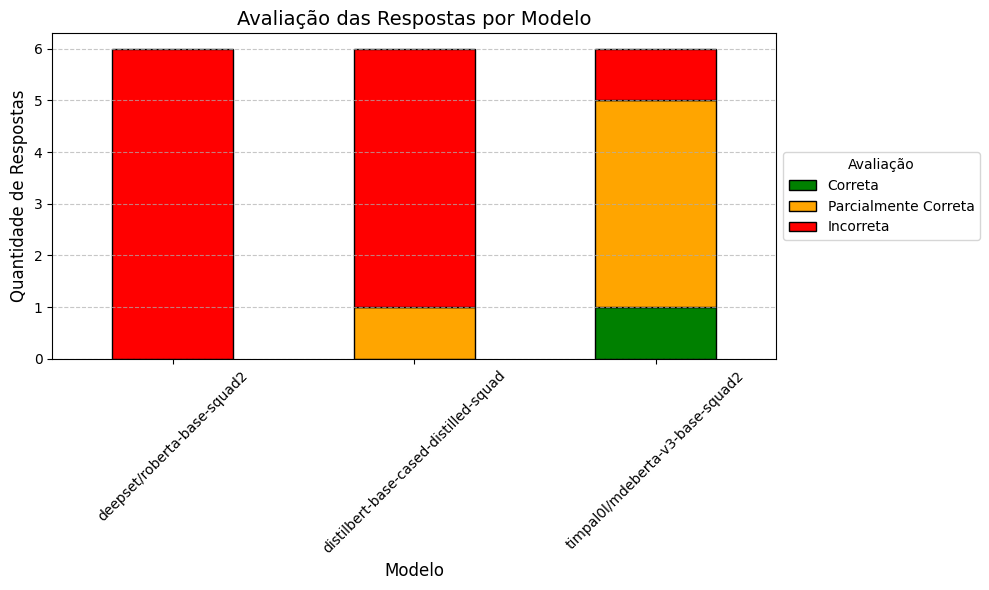

In [27]:
# Exibir tabela de avaliação

def exibir_resultados_formatados(df):
    modelos = df["Modelo"].unique()

    for modelo in modelos:
        print(f"\n\nResultados para: {modelo}")
        df_modelo = df[df["Modelo"] == modelo]
        styled = df_modelo.style.set_properties(**{'text-align': 'center'}) \
            .set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) \
            .set_caption(f"Modelo: {modelo}")
        display(styled)

    print("\n\n\n")
    # Gráfico comparativo de avaliações
    comparativo = df.groupby(["Modelo", "Avaliação"]).size().unstack(fill_value=0)

    # Ordena colunas para manter ✔️ ➖ ❌ nessa ordem
    colunas_ordenadas = ["✔️", "➖", "❌"]
    comparativo = comparativo[[col for col in colunas_ordenadas if col in comparativo.columns]]

    # Define cores personalizadas
    cores = {
        "✔️": "green",
        "➖": "orange",
        "❌": "red"
    }
    cores_usadas = [cores[c] for c in comparativo.columns]

    # Plota
    ax = comparativo.plot(
        kind="bar",
        stacked=True,
        figsize=(10, 6),
        color=cores_usadas,
        edgecolor='black'
    )

    plt.title("Avaliação das Respostas por Modelo", fontsize=14)
    plt.xlabel("Modelo", fontsize=12)
    plt.ylabel("Quantidade de Respostas", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Legenda personalizada
    legenda = {
        "✔️": "Correta",
        "➖": "Parcialmente Correta",
        "❌": "Incorreta"
    }
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [legenda.get(lbl, lbl) for lbl in labels]
    ax.legend(
    handles, new_labels,
    title="Avaliação",
    loc='center left',
    bbox_to_anchor=(1, 0.5)
    )

    plt.tight_layout()
    plt.show()


df_avaliacao = pd.DataFrame(avaliacoes)
exibir_resultados_formatados(df_avaliacao)

In [28]:
# Modelo de embedding multilíngue
print("Carregando modelo de embedding 'paraphrase-multilingual-mpnet-base-v2'...")
embedding_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

# Função de divisão de texto com sobreposição
def split_context_com_overlap(text, max_len=500, overlap=50):
    sentences = re.split(r'(?<=[.!?])\s+', text.replace('\n', ' '))
    blocks = []
    current_block = ""
    for sentence in sentences:
        if len(current_block) + len(sentence) + 1 <= max_len:
            current_block += sentence + " "
        else:
            if current_block: blocks.append(current_block.strip())
            start_index = max(0, len(current_block) - overlap)
            current_block = current_block[start_index:] + " " + sentence + " "
    if current_block: blocks.append(current_block.strip())
    return blocks

# Combinar todos os textos e criar os blocos
texto_completo = docx_text + "\n\n" + pdf_text
blocos_de_texto = split_context_com_overlap(texto_completo)
print(f"Texto dividido em {len(blocos_de_texto)} blocos para indexação.")

# Criar os embeddings
print("Criando embeddings para os blocos de texto...")
embeddings = embedding_model.encode(blocos_de_texto, convert_to_tensor=True, show_progress_bar=True)

# Normalizar e criar índice FAISS
embeddings_cpu = embeddings.cpu().numpy()
faiss.normalize_L2(embeddings_cpu)
embedding_dim = embeddings_cpu.shape[1]
index = faiss.IndexFlatIP(embedding_dim)
index.add(embeddings_cpu)
print("Índice FAISS para busca de similaridade criado com sucesso.")

Carregando modelo de embedding 'paraphrase-multilingual-mpnet-base-v2'...
Texto dividido em 813 blocos para indexação.
Criando embeddings para os blocos de texto...


Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Índice FAISS para busca de similaridade criado com sucesso.


In [42]:
def get_rag_answer_with_context(question, qa_pipeline, top_k=5):
    question_embedding = embedding_model.encode([question]).astype('float32')
    faiss.normalize_L2(question_embedding)
    _, indices = index.search(question_embedding, top_k)
    relevant_contexts = [blocos_de_texto[i] for i in indices[0]]

    best_answer = {"answer": "", "score": 0.0}
    best_context = ""

    for context in relevant_contexts:
        if not context.strip(): continue
        result = qa_pipeline(question=question, context=context)
        if result["score"] > best_answer["score"]:
            best_answer = result
            best_context = context

    return best_answer, best_context,relevant_contexts

qa_model_names = [
    "deepset/roberta-base-squad2",
    "distilbert-base-cased-distilled-squad",
    "timpal0l/mdeberta-v3-base-squad2"
]

perguntas_respostas_por_doc = {
     "Dicionário de Dados": {
        "Qual o nome da tabela LFCES004 no banco de produção federal?": "TB_ESTABELECIMENTO",
        "Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?": "Quantidade de Leitos Disponíveis para o SUS.( Para os Estabelecimentos vinculados ao SUS.)",
        "Quais são os domínios do campo INDGESTOR, da tabela FCESGEST?": "1 – Secretaria Estadual, 2 – Região de Saúde, 3 – Secretaria Municipal Não Pleno, 4 – Módulo Assistencial, 5 – Distrito Sanitário, 6 – DataSus, 7 – 5éc. Municipal Pleno, 8 – Capital, 9 – Microrregião"
    },
    "Doenças Respiratórias Crônicas": {
        "Quais são os principais fatores de risco preveníveis para doenças respiratórias crônicas (DRC)?": "Tabagismo, poluição ambiental, alérgenos, agentes ocupacionais, pneumonia, bronquiolite e tuberculose.",
        "Qual é a definição clássica de sintomático respiratório?": "É o indivíduo que apresenta tosse, associada ou não a outra alteração respiratória, por algumas semanas.",
        "Como a tosse pode ser classificada?": "Em aguda até três semanas de duração; subaguda de três a oito semanas; e crônica se superior a oito semanas."
    }
}

final_results = []
print("\n--- Iniciando Avaliação e Captura de Contexto ---")

for model_name in qa_model_names:
    print(f"\nCarregando e avaliando modelo: {model_name}")
    qa_pipeline = pipeline("question-answering", model=model_name, tokenizer=model_name)

    for doc_name, qa_pairs in perguntas_respostas_por_doc.items():
        for question, correct_answer in qa_pairs.items():
            print(f"  -> Pergunta: {question[:60]}...")
            rag_result, used_context, all_context = get_rag_answer_with_context(question, qa_pipeline)
            final_results.append({
                "Modelo": model_name.split('/')[-1],
                "Documento": doc_name,
                "Pergunta": question,
                "Resposta": rag_result["answer"],
                "Resposta Esperada": correct_answer,
                "Confiança": round(rag_result["score"], 4),
                "Contexto Utilizado": used_context,
                "Todo Contexto": all_context
            })

print("\n--- Avaliação concluída! ---")


--- Iniciando Avaliação e Captura de Contexto ---

Carregando e avaliando modelo: deepset/roberta-base-squad2


Device set to use cuda:0


  -> Pergunta: Qual o nome da tabela LFCES004 no banco de produção federal?...
  -> Pergunta: Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QT...
  -> Pergunta: Quais são os domínios do campo INDGESTOR, da tabela FCESGEST...
  -> Pergunta: Quais são os principais fatores de risco preveníveis para do...
  -> Pergunta: Qual é a definição clássica de sintomático respiratório?...
  -> Pergunta: Como a tosse pode ser classificada?...

Carregando e avaliando modelo: distilbert-base-cased-distilled-squad


Device set to use cuda:0


  -> Pergunta: Qual o nome da tabela LFCES004 no banco de produção federal?...
  -> Pergunta: Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QT...
  -> Pergunta: Quais são os domínios do campo INDGESTOR, da tabela FCESGEST...
  -> Pergunta: Quais são os principais fatores de risco preveníveis para do...
  -> Pergunta: Qual é a definição clássica de sintomático respiratório?...
  -> Pergunta: Como a tosse pode ser classificada?...

Carregando e avaliando modelo: timpal0l/mdeberta-v3-base-squad2


Device set to use cuda:0


  -> Pergunta: Qual o nome da tabela LFCES004 no banco de produção federal?...
  -> Pergunta: Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QT...
  -> Pergunta: Quais são os domínios do campo INDGESTOR, da tabela FCESGEST...
  -> Pergunta: Quais são os principais fatores de risco preveníveis para do...
  -> Pergunta: Qual é a definição clássica de sintomático respiratório?...
  -> Pergunta: Como a tosse pode ser classificada?...

--- Avaliação concluída! ---



--- Tabela Comparativa de Desempenho dos Modelos com RAG Melhorada ---


,Modelo,Documento,Pergunta,Resposta,Resposta Esperada,Avaliação,Similaridade,Confiança
0,roberta-base-squad2,Dicionário de Dados,Qual o nome da tabela LFCES004 no banco de produção federal?,o de Registro,TB_ESTABELECIMENTO,❌,0.415300,0.000000
1,roberta-base-squad2,Dicionário de Dados,"Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?",Data de Ativação,Quantidade de Leitos Disponíveis para o SUS.( Para os Estabelecimentos vinculados ao SUS.),❌,0.274800,0.000000
2,roberta-base-squad2,Dicionário de Dados,"Quais são os domínios do campo INDGESTOR, da tabela FCESGEST?",DOMÍNIOS,"1 – Secretaria Estadual, 2 – Região de Saúde, 3 – Secretaria Municipal Não Pleno, 4 – Módulo Assistencial, 5 – Distrito Sanitário, 6 – DataSus, 7 – 5éc. Municipal Pleno, 8 – Capital, 9 – Microrregião",❌,0.368500,0.001700
3,roberta-base-squad2,Doenças Respiratórias Crônicas,Quais são os principais fatores de risco preveníveis para doenças respiratórias crônicas (DRC)?,DPOC em adultos ou bronquiolite,"Tabagismo, poluição ambiental, alérgenos, agentes ocupacionais, pneumonia, bronquiolite e tuberculose.",❌,0.561800,0.073900
4,roberta-base-squad2,Doenças Respiratórias Crônicas,Qual é a definição clássica de sintomático respiratório?,o indivíduo,"É o indivíduo que apresenta tosse, associada ou não a outra alteração respiratória, por algumas semanas.",➖,0.285200,0.428800
5,roberta-base-squad2,Doenças Respiratórias Crônicas,Como a tosse pode ser classificada?,crônica,Em aguda até três semanas de duração; subaguda de três a oito semanas; e crônica se superior a oito semanas.,➖,0.360600,0.038600
6,distilbert-base-cased-distilled-squad,Dicionário de Dados,Qual o nome da tabela LFCES004 no banco de produção federal?,o de Registro,TB_ESTABELECIMENTO,❌,0.415300,0.108500
7,distilbert-base-cased-distilled-squad,Dicionário de Dados,"Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?",Código,Quantidade de Leitos Disponíveis para o SUS.( Para os Estabelecimentos vinculados ao SUS.),❌,0.312300,0.006000
8,distilbert-base-cased-distilled-squad,Dicionário de Dados,"Quais são os domínios do campo INDGESTOR, da tabela FCESGEST?",VARCHAR2(200),"1 – Secretaria Estadual, 2 – Região de Saúde, 3 – Secretaria Municipal Não Pleno, 4 – Módulo Assistencial, 5 – Distrito Sanitário, 6 – DataSus, 7 – 5éc. Municipal Pleno, 8 – Capital, 9 – Microrregião",❌,0.156600,0.000900
9,distilbert-base-cased-distilled-squad,Doenças Respiratórias Crônicas,Quais são os principais fatores de risco preveníveis para doenças respiratórias crônicas (DRC)?,entre as principais,"Tabagismo, poluição ambiental, alérgenos, agentes ocupacionais, pneumonia, bronquiolite e tuberculose.",❌,0.411400,0.017200



--- Gráfico Comparativo de Avaliações por Modelo ---


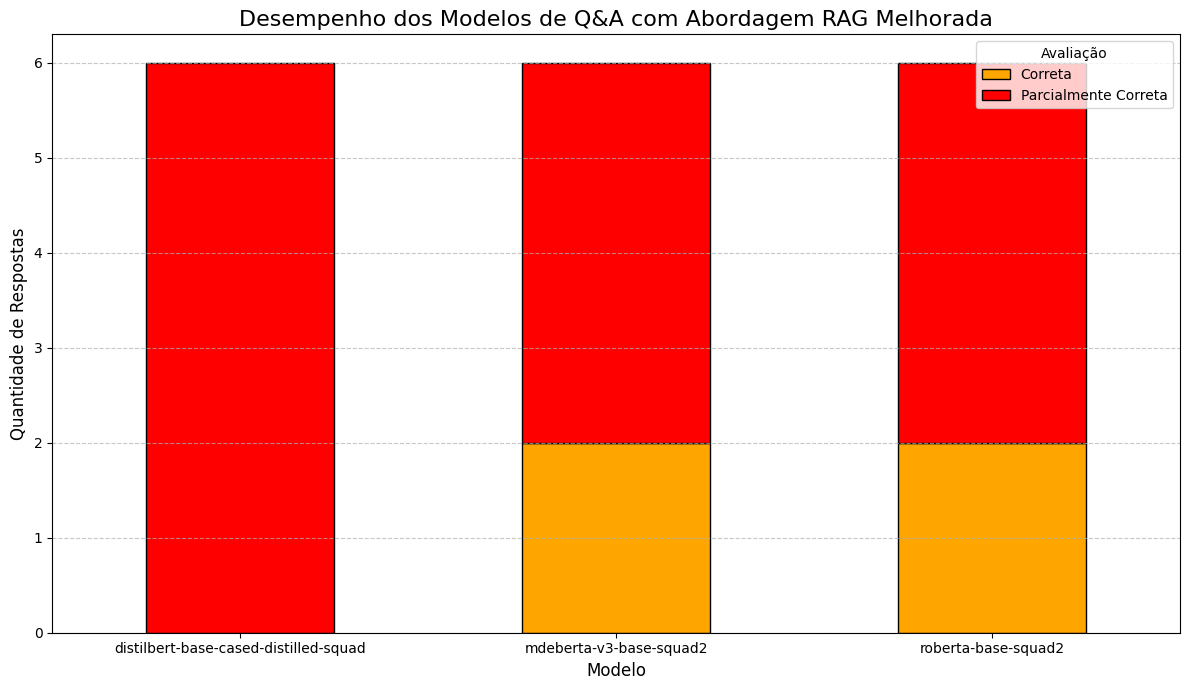

In [45]:
def evaluate_manual_answer(model_ans, correct_ans):
    model_ans_lower = model_ans.lower().strip().replace('.', '')
    correct_ans_lower = correct_ans.lower().strip().replace('.', '')
    if not model_ans_lower: return "❌"
    if model_ans_lower == correct_ans_lower: return "✔️"
    if model_ans_lower in correct_ans_lower or correct_ans_lower in model_ans_lower: return "➖"
    return "❌"

evaluations = []
for r in final_results:
    model_answer = r["Resposta"]
    correct_answer = r["Resposta Esperada"]

    emb1 = embedding_model.encode(model_answer, convert_to_tensor=True)
    emb2 = embedding_model.encode(correct_answer, convert_to_tensor=True)
    similarity = util.cos_sim(emb1, emb2).item()
    manual_eval = evaluate_manual_answer(model_answer, correct_answer)

    evaluations.append({
        "Modelo": r["Modelo"],
        "Documento": r["Documento"],
        "Pergunta": r["Pergunta"],
        "Resposta": model_answer,
        "Resposta Esperada": correct_answer,
        "Avaliação": manual_eval,
        "Similaridade": round(similarity, 4),
        "Confiança": r["Confiança"]
    })

df_evaluation = pd.DataFrame(evaluations)

print("\n--- Tabela Comparativa de Desempenho dos Modelos com RAG Melhorada ---")
display(df_evaluation.style.set_properties(**{'text-align': 'left'}).set_table_styles([dict(selector='th', props=[('text-align', 'left')])]))

print("\n--- Gráfico Comparativo de Avaliações por Modelo ---")
comparativo = df_evaluation.groupby(["Modelo", "Avaliação"]).size().unstack(fill_value=0)
colunas_ordenadas = [col for col in ["✔️", "➖", "❌"] if col in comparativo.columns]
comparativo = comparativo[colunas_ordenadas]

ax = comparativo.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 7),
    color={"✔️": "green", "➖": "orange", "❌": "red"},
    edgecolor='black'
)

plt.title("Desempenho dos Modelos de Q&A com Abordagem RAG Melhorada", fontsize=16)
plt.xlabel("Modelo", fontsize=12)
plt.ylabel("Quantidade de Respostas", fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Avaliação", labels=["Correta", "Parcialmente Correta", "Incorreta"])
plt.tight_layout()
plt.show()

In [46]:
for result in final_results:
    print("-" * 80)
    print(f"Modelo: {result['Modelo']}")
    print(f"Pergunta: {result['Pergunta']}")
    print(f"Resposta Gerada: {result['Resposta']} (Confiança: {result['Confiança']})")
    print("\n--- Contexto Completo ---")
    print(result['Todo Contexto'])
    print("\n--- Contexto Utilizado para a Resposta ---")
    print(result['Contexto Utilizado'])
    print("-" * 80 + "\n")

--------------------------------------------------------------------------------
Modelo: roberta-base-squad2
Pergunta: Qual o nome da tabela LFCES004 no banco de produção federal?
Resposta Gerada: o de Registro (Confiança: 0.0)

--- Contexto Completo ---
['o de Registro | C – Regras Contratuais E – Estab.  Ensinos F – Hosp.', 'o de Registro | C – Regras Contratuais E – Estab.  Ensinos F – Hosp.', 'o de Registro | C – Regras Contratuais E – Estab.  Ensinos F – Hosp.', 'o de Registro | C – Regras Contratuais E – Estab.  Ensinos F – Hosp.', 'o de Registro | C – Regras Contratuais E – Estab.  Ensinos F – Hosp.']

--- Contexto Utilizado para a Resposta ---
o de Registro | C – Regras Contratuais E – Estab.  Ensinos F – Hosp.
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Modelo: roberta-base-squad2
Pergunta: Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?
Re